# CS:GO Round Winner Classification

### About CS:GO

CS:GO is a tactical shooter, where two teams (CT and Terrorist) play for a best of 30 rounds, with each round being 1 minute and 55 seconds. There are 5 players on each team (10 in total) and the first team to reach 16 rounds wins the game. At the start, one team plays as CT and the other as Terrorist. After 15 rounds played, the teams swap side. There are 7 different maps a game can be played on. You win a round as Terrorist by either planting the bomb and making sure it explodes, or by eliminating the other team. You win a round as CT by either eliminating the other team, or by disarming the bomb, should it have been planted.

### About dataset

The dataset was originally published by Skybox as part of their CS:GO AI Challenge, running from Spring to Fall 2020. The data set consists of ~700 demos from high level tournament play in 2019 and 2020. Warmup rounds and restarts have been filtered, and for the remaining live rounds a round snapshot have been recorded every 20 seconds until the round is decided. Following the initial publication, It has been pre-processed and flattened to improve readability and make it easier for algorithms to process. The total number of snapshots is 122411.

| Variable         | Definition                                                            | Key                                                                     |
|------------------|-----------------------------------------------------------------------|-------------------------------------------------------------------------|
| time_left        | The time left in the current round.                                   |                                                                         |
| ct_score         | The current score of the Counter-Terrorist team.                      |                                                                         |
| t_score          | The current score of the Terrorist team.                              |                                                                         |
| map              | The map the round is being played on.                                  | E.g. de_dust2, de_inferno and de_overpass                                |
| bomb_planted     | If the bomb has been planted or not.                                   | False = No, True = Yes                                                 |
| ct_health        | The total health of all Counter-Terrorist players.                    | Player health in range 0-100.                                           |
| t_health         | The total health of all Terrorist players.                             | Player health in range 0-100.                                           |
| ct_armor         | The total armor of all Counter-Terrorist players.                      |                                                                         |
| t_armor          | The total armor of all Terrorist players.                              |                                                                         |
| ct_money         | The total bankroll of all Counter-Terrorist players.                   | Amount in USD.                                                          |
| t_money          | The total bankroll of all Terrorist players.                           | Amount in USD.                                                          |
| ct_helmets       | Number of helmets on the Counter-Terrorist team.                       |                                                                         |
| t_helmets        | Number of helmets on the Terrorist team.                               |                                                                         |
| ct_defuse_kits   | Number of defuse kits on the Counter-Terrorist team.                   |                                                                         |
| ct_players_alive | Number of alive players on the Counter-Terrorist team.                 | Range 0 to 5.                                                           |
| t_players_alive  | Number of alive players on the Terrorist team.                         | Range 0 to 5.                                                           |
| ct_weapon_X      | Weapon X count on Counter-Terrorist team.                              | E.g. Ak47, Deagle and UMP45.                                             |
| t_weapon_X       | Weapon X count on Terrorist team.                                      | E.g. Ak47, Deagle and UMP45.                                             |
| ct_grenade_X     | Grenade X count on Counter-Terrorist team.                             | E.g. HeGrenade, Flashbang.                                               |
| t_grenade_X      | Grenade X count on Terrorist team.                                     | E.g. HeGrenade, Flashbang.                                               |
| round_winner     | Winner.                                                               | CT = Counter-Terrorist, T = Terrorist                                    |


In [37]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense

In [132]:
#read data
df = pd.read_csv('csgo_round_snapshots.csv')


In [133]:
#preparing the data

#changing the map names to numbers
maps = {'de_dust2': 0, 'de_mirage': 1, 'de_nuke': 2, 'de_inferno': 3, 'de_train': 4, 'de_overpass': 5, 'de_vertigo': 6}

df['map'] = df['map'].map(maps)

print(df.shape)
print(df.isnull().sum())

#delete rows with missing values
df = df.dropna()
print(df.shape)

(122410, 97)
time_left                      0
ct_score                       0
t_score                        0
map                          145
bomb_planted                   0
                            ... 
ct_grenade_molotovgrenade      0
t_grenade_molotovgrenade       0
ct_grenade_decoygrenade        0
t_grenade_decoygrenade         0
round_winner                   0
Length: 97, dtype: int64
(122265, 97)


In [134]:
#analyzing range of values for each column
for column in df.columns:
    print(f"Range of values for {column}: {df[column].min()} - {df[column].max()}")

Range of values for time_left: 0.01 - 175.0
Range of values for ct_score: 0.0 - 32.0
Range of values for t_score: 0.0 - 33.0
Range of values for map: 0.0 - 6.0
Range of values for bomb_planted: False - True
Range of values for ct_health: 0.0 - 500.0
Range of values for t_health: 0.0 - 600.0
Range of values for ct_armor: 0.0 - 500.0
Range of values for t_armor: 0.0 - 500.0
Range of values for ct_money: 0.0 - 80000.0
Range of values for t_money: 0.0 - 80000.0
Range of values for ct_helmets: 0.0 - 5.0
Range of values for t_helmets: 0.0 - 5.0
Range of values for ct_defuse_kits: 0.0 - 5.0
Range of values for ct_players_alive: 0.0 - 5.0
Range of values for t_players_alive: 0.0 - 6.0
Range of values for ct_weapon_ak47: 0.0 - 4.0
Range of values for t_weapon_ak47: 0.0 - 5.0
Range of values for ct_weapon_aug: 0.0 - 5.0
Range of values for t_weapon_aug: 0.0 - 3.0
Range of values for ct_weapon_awp: 0.0 - 5.0
Range of values for t_weapon_awp: 0.0 - 4.0
Range of values for ct_weapon_bizon: 0.0 - 0.

In [135]:
#removing mistakes in t_players_alive (max value is 5)
df = df.drop(df[df['t_players_alive'] > 5].index)
df = df.drop(df[df['t_health'] > 500].index)
print(df.shape)

(122264, 97)


<AxesSubplot:>

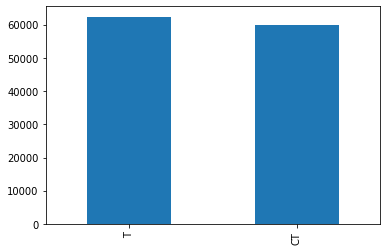

In [136]:
#plotting the amount of rounds won by each team
df['round_winner'].value_counts().plot.bar()

In [137]:
#splitting the data into training and testing sets
X = df.values[:, :-1]
y = df.values[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=278823)

[Text(0.23599757888830944, 0.9893617021276596, 'x[8] <= 100.5\ngini = 0.5\nsamples = 85584\nvalue = [41954, 43630]'),
 Text(0.08194311303516519, 0.9680851063829787, 'x[7] <= 110.5\ngini = 0.335\nsamples = 19856\nvalue = [15629, 4227]'),
 Text(0.04225159930715284, 0.9468085106382979, 'x[8] <= 6.0\ngini = 0.499\nsamples = 5159\nvalue = [2467, 2692]'),
 Text(0.025614869858497886, 0.925531914893617, 'x[7] <= 70.5\ngini = 0.471\nsamples = 2897\nvalue = [1799, 1098]'),
 Text(0.02022547031574394, 0.9042553191489362, 'x[87] <= 0.5\ngini = 0.5\nsamples = 1708\nvalue = [856, 852]'),
 Text(0.017816867630021518, 0.8829787234042553, 'x[34] <= 0.5\ngini = 0.497\nsamples = 1517\nvalue = [696, 821]'),
 Text(0.01769869838650046, 0.8617021276595744, 'x[13] <= 0.5\ngini = 0.499\nsamples = 1451\nvalue = [696, 755]'),
 Text(0.014358608559068847, 0.8404255319148937, 'x[10] <= 18075.0\ngini = 0.497\nsamples = 1367\nvalue = [631, 736]'),
 Text(0.012283336612666878, 0.8191489361702128, 'x[9] <= 4700.0\ngini = 

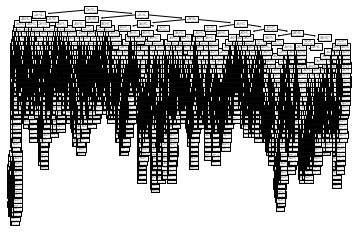

In [138]:
#tree classifier
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

tree.plot_tree(clf)

In [139]:
#accuracy of the tree classifier
clf.score(X_test, y_test)

0.8170119956379498

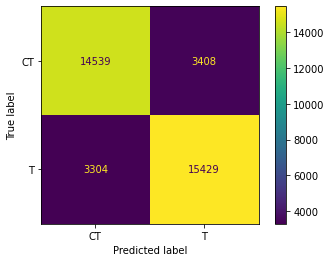

In [140]:
#confusion matrix
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

[Text(0.47771773182957394, 0.9444444444444444, 'x[8] <= 100.5\ngini = 0.5\nsamples = 85585\nvalue = [42005, 43580]'),
 Text(0.22979323308270677, 0.8333333333333334, 'x[7] <= 110.5\ngini = 0.335\nsamples = 19865\nvalue = [15642, 4223]'),
 Text(0.10823934837092732, 0.7222222222222222, 'x[8] <= 15.5\ngini = 0.499\nsamples = 5163\nvalue = [2490, 2673]'),
 Text(0.05294486215538847, 0.6111111111111112, 'x[7] <= 70.5\ngini = 0.469\nsamples = 2901\nvalue = [1813, 1088]'),
 Text(0.023182957393483708, 0.5, 'x[87] <= 0.5\ngini = 0.5\nsamples = 1703\nvalue = [862, 841]'),
 Text(0.012531328320802004, 0.3888888888888889, 'x[34] <= 0.5\ngini = 0.497\nsamples = 1505\nvalue = [694, 811]'),
 Text(0.010025062656641603, 0.2777777777777778, 'x[13] <= 0.5\ngini = 0.5\nsamples = 1433\nvalue = [694, 739]'),
 Text(0.005012531328320802, 0.16666666666666666, 'x[5] <= 450.0\ngini = 0.498\nsamples = 1356\nvalue = [634, 722]'),
 Text(0.002506265664160401, 0.05555555555555555, 'gini = 0.36\nsamples = 51\nvalue = [39

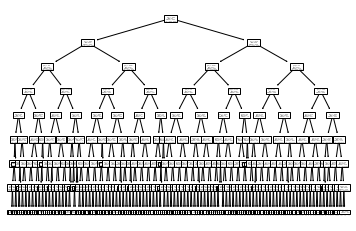

In [9]:
#tree classifier with max depth of 8
clf = tree.DecisionTreeClassifier(max_depth=8)
clf = clf.fit(X_train, y_train)

tree.plot_tree(clf)

In [10]:
#accuracy of the tree classifier
clf.score(X_test, y_test)

0.7488276990185387

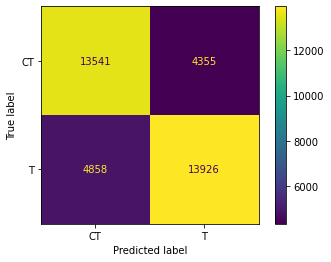

In [11]:
#confusion matrix
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [141]:
#bayes classifier
model = GaussianNB()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7297437295528899

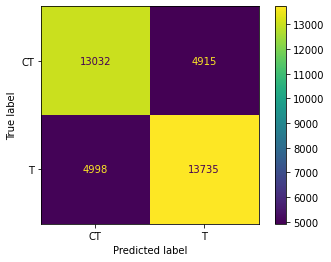

In [142]:
#confusion matrix
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [143]:
#k nearest neighbors classifier with 3 neighbors
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.7673664122137405

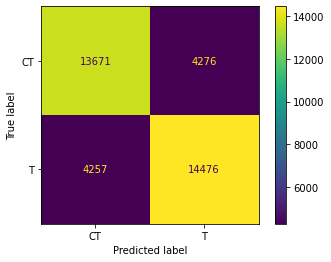

In [144]:
#confusion matrix
predictions = knn.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [16]:
#k nearest neighbors classifier with 5 neighbors
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.7537622682660851

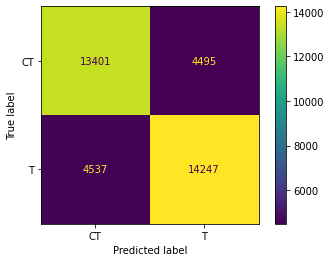

In [17]:
#confusion matrix
predictions = knn.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [18]:
#k nearest neighbors classifier with 11 neighbors
knn = KNeighborsClassifier(n_neighbors=11, metric='euclidean')
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.7313794983642312

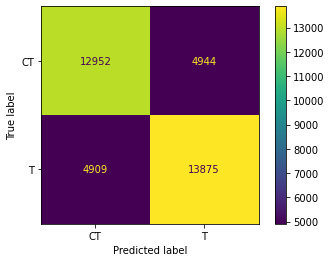

In [19]:
#confusion matrix
predictions = knn.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [145]:
#preparing the data for the neural network

#changing round_winner and bomb_planted numbers
df['round_winner'] = df['round_winner'].map({'CT': 0, 'T': 1})
df['bomb_planted'] = df['bomb_planted'].map({False: 0, True: 1})

#rmove rows with missing values
df = df.dropna()

In [146]:
#splitting the data into training and testing sets
X = df.values[:, :-1]
y = df.values[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=278823)

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [5]:
#creating the neural network
model = Sequential()
model.add(Dense(8, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [6]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
history = model.fit(X_train, y_train, epochs=250, verbose=0, validation_data=(X_test, y_test))

In [8]:
#accuracy of the neural network
predictions_train = model.predict(X_train).round()
print(accuracy_score(predictions_train, y_train))

predictions_test = model.predict(X_test).round()
print(accuracy_score(predictions_test, y_test))

2675/2675 [==============================] - 4s 1ms/step
0.755225798913361
1147/1147 [==============================] - 1s 1ms/step
0.7460196292257361


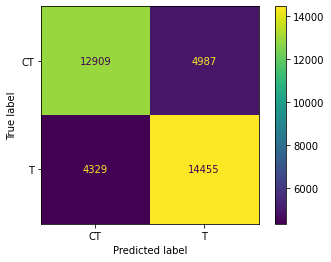

In [9]:
#confusion matrix
cm = confusion_matrix(y_test, predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CT', 'T'])
disp.plot()

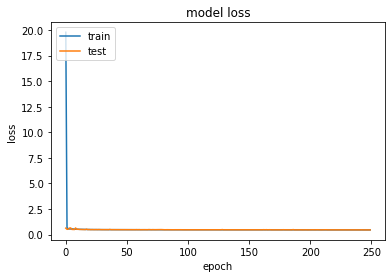

In [10]:
#plotting the model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [5]:
#another neural network
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [6]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
history = model.fit(X_train, y_train, epochs=250, verbose=0, validation_data=(X_test, y_test))

In [8]:
#accuracy of the neural network
predictions_train = model.predict(X_train).round()
print(accuracy_score(predictions_train, y_train))

predictions_test = model.predict(X_test).round()
print(accuracy_score(predictions_test, y_test))

2675/2675 [==============================] - 2s 773us/step
0.7459835251504352
1147/1147 [==============================] - 1s 837us/step
0.7420937840785169


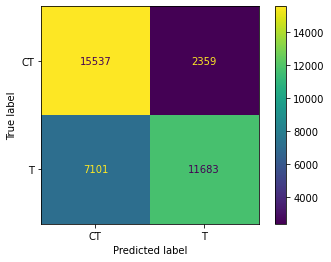

In [9]:
#confusion matrix
cm = confusion_matrix(y_test, predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CT', 'T'])
disp.plot()

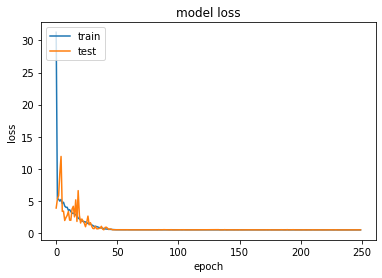

In [10]:
#plotting the model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
#another neural network
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
history = model.fit(X_train, y_train, epochs=250, verbose=0, validation_data=(X_test, y_test))

In [14]:
#accuracy of the neural network
predictions_train = model.predict(X_train).round()
print(accuracy_score(predictions_train, y_train))

predictions_test = model.predict(X_test).round()
print(accuracy_score(predictions_test, y_test))

2675/2675 [==============================] - 3s 948us/step
0.7482970146637845
1147/1147 [==============================] - 1s 912us/step
0.7412486368593239


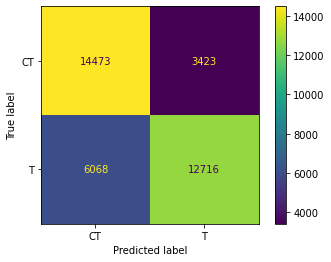

In [15]:
#confusion matrix
cm = confusion_matrix(y_test, predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CT', 'T'])
disp.plot()

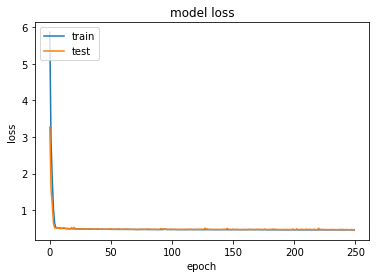

In [16]:
#plotting the model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Preprocessing

In [50]:
#removing columns with all 0 values
zero_cols = [col for col in df.columns if (df[col] == 0).all()]

print(zero_cols)
print(df.shape)


['ct_weapon_bizon', 'ct_weapon_g3sg1', 't_weapon_m249', 'ct_weapon_negev', 'ct_weapon_r8revolver', 'ct_weapon_sawedoff']
(122264, 97)


In [51]:
df = df.drop(zero_cols, axis=1)
print(df.shape)

(122264, 91)


In [52]:
#normalizing the data into a range of 0 to 1
scaler = MinMaxScaler()

scaler.fit(df)

df_scaled = scaler.transform(df)

df = pd.DataFrame(df_scaled, columns=df.columns)

df.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,1.000000,0.00000,0.0,0.0,0.0,1.000,1.0,0.000,0.0,0.050000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.891594,0.00000,0.0,0.0,0.0,1.000,1.0,0.800,0.6,0.007500,...,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.548717,0.00000,0.0,0.0,0.0,0.782,0.8,0.588,0.4,0.009375,...,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.434425,0.00000,0.0,0.0,0.0,0.782,0.8,0.588,0.4,0.009375,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.999829,0.03125,0.0,0.0,0.0,1.000,1.0,0.384,0.0,0.229375,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
#using PCA to reduce the number of features
X = df.values[:, :-1]
y = df.values[:, -1]

pca = PCA(n_components=15)
pca.fit(X)

print(pca.explained_variance_ratio_)

X = pca.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=278823)

[0.28801436 0.1528314  0.13341267 0.04281175 0.03465426 0.03290437
 0.02684806 0.02603111 0.021861   0.01799584 0.01673563 0.01321397
 0.01261014 0.01124265 0.00981136]


In [85]:
#creating the neural network
model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [86]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [87]:
history = model.fit(X_train, y_train, epochs=250, verbose=0, validation_data=(X_test, y_test))

In [91]:
#accuracy of the neural network
predictions_train = model.predict(X_train).round()
print(accuracy_score(predictions_train, y_train))

predictions_test = model.predict(X_test).round()
print(accuracy_score(predictions_test, y_test))

2675/2675 [==============================] - 2s 844us/step
0.7592190128996074
1147/1147 [==============================] - 1s 849us/step
0.75


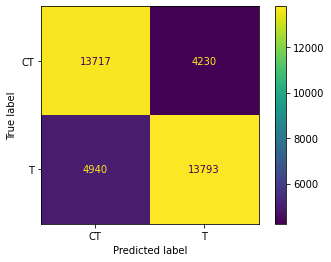

In [92]:
#confusion matrix
cm = confusion_matrix(y_test, predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CT', 'T'])
disp.plot()

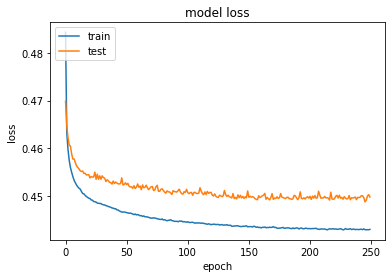

In [94]:
#plotting the model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [119]:
#another neural network
model = Sequential()
model.add(Dense(5, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [120]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [121]:
history = model.fit(X_train, y_train, epochs=250, verbose=0, validation_data=(X_test, y_test))

In [122]:
#accuracy of the neural network
predictions_train = model.predict(X_train).round()
print(accuracy_score(predictions_train, y_train))

predictions_test = model.predict(X_test).round()
print(accuracy_score(predictions_test, y_test))

2675/2675 [==============================] - 2s 827us/step
0.7532716395587961
1147/1147 [==============================] - 1s 864us/step
0.7488004362050164


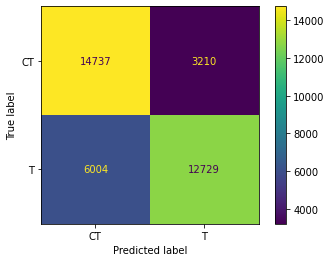

In [123]:
#confusion matrix
cm = confusion_matrix(y_test, predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CT', 'T'])
disp.plot()

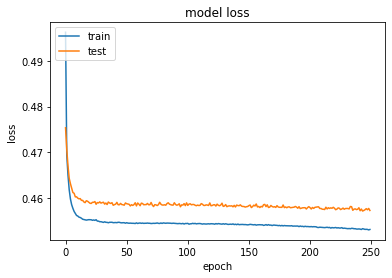

In [124]:
#plotting the model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[Text(0.47846359726024906, 0.9888888888888889, 'x[1] <= -0.069\ngini = 0.5\nsamples = 85584\nvalue = [41954, 43630]'),
 Text(0.19518951989534214, 0.9666666666666667, 'x[0] <= 0.33\ngini = 0.391\nsamples = 39109\nvalue = [10441, 28668]'),
 Text(0.09369258199493397, 0.9444444444444444, 'x[5] <= -0.154\ngini = 0.276\nsamples = 24731\nvalue = [4094, 20637]'),
 Text(0.02932146498471563, 0.9222222222222223, 'x[1] <= -0.409\ngini = 0.479\nsamples = 4752\nvalue = [1891, 2861]'),
 Text(0.012125563371626383, 0.9, 'x[4] <= 0.146\ngini = 0.32\nsamples = 2067\nvalue = [413, 1654]'),
 Text(0.004655858875593074, 0.8777777777777778, 'x[5] <= -0.436\ngini = 0.245\nsamples = 1516\nvalue = [217, 1299]'),
 Text(0.0014015917522219926, 0.8555555555555555, 'x[6] <= 0.056\ngini = 0.45\nsamples = 126\nvalue = [43, 83]'),
 Text(0.0005239595335409319, 0.8333333333333334, 'x[3] <= 0.033\ngini = 0.494\nsamples = 36\nvalue = [20, 16]'),
 Text(0.0003143757201245591, 0.8111111111111111, 'x[11] <= 0.134\ngini = 0.432\

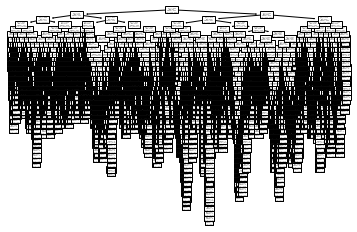

In [125]:
#tree classifier
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

tree.plot_tree(clf)

In [126]:
#accuracy of the tree classifier
clf.score(X_test, y_test)

0.7415757906215922

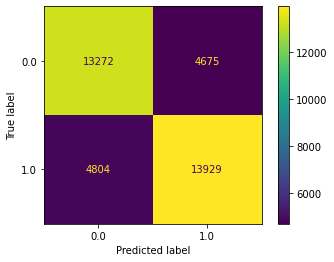

In [127]:
#confusion matrix
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [128]:
#bayes classifier
model = GaussianNB()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7353326063249728

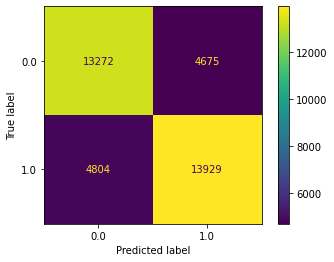

In [129]:
#confusion matrix
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [130]:
#k nearest neighbors classifier with 3 neighbors
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.7863685932388222

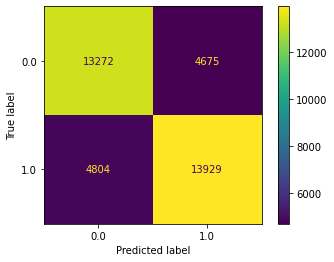

In [131]:
#confusion matrix
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

# SUMMARY

|      Classifier     | Data accuracy | Preprocessed data  accuracy |
|:-------------------:|:-------------:|:---------------------------:|
|    Decision tree    |     81.7%     |            74.2%            |
|     Naive Bayes     |     73.0%     |            73.5%            |
| 3 nearest neighbors |     76.7%     |            78.6%            |
|    Neural network   |     74.2%     |            74.9%            |

Contrary to expectations, preprocessing did not significantly improve the accuracy of the classifiers. It also made neural network models overfitted. The best performance got the decision tree before preprocessing (81.7%). Another decision tree with a max depth of 8 was less accurate. In the case of k nearest neighbors classifiers, the best was the one with 3 neighbors. 

# LINKS

Kaggle dataset: https://www.kaggle.com/datasets/christianlillelund/csgo-round-winner-classification

Skybox website: https://skybox.gg/

Learn more about CS:GO: https://en.wikipedia.org/wiki/Counter-Strike:_Global_Offensive

View CS:GO on Steam Store: https://store.steampowered.com/app/730/CounterStrike_Global_Offensive/

Find in-depth information on competitive CS:GO: https://www.hltv.org/